# Download Chl-a products of multiple sources and make regional plots

**Author:** Jiaxu Zhang[![](orcid.png)](https://orcid.org/0000-0002-8564-3026) (UW, NOAA, jiaxu.zhang@noaa.gov)

This tutorial demonstrates how to download chlorophyll-a concentration products from various satellites and create regional plots at publication quality.

## Contents

1. [Download and process PACE OCI data](#1.-Download-and-process-PACE-OCI-data)
2. [Download and process SNPP VIIRS data](#2.-Download-and-process-SNPP-VIIRS-data)
3. [Download and process MODIS data](#3.-Download-and-process-MODIS-data)
4. [Download and process merged data (OC CCI)](#4.-Download-and-process-merged-data-(OC-CCI))
5. [Combine the plots side by side](#5.-Combine-the-plots-side-by-side)


We begin by importing the packages used in this notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import earthaccess
import requests

import sys
sys.path.append("../scripts")
import PACEToolkit.regional_plot as regional_plot

## 1. Download and Process PACE OCI Data

[This tutorial](https://pacehackweek.github.io/pace-2024/presentations/hackweek/earthdata_cloud_access.html) demonstrates how to use the `earthaccess` package to create PACE OCI Chl-a plots without downloading a local copy. In this tutorial, we will use the `hypercoast` package to achieve the same goal.

You may need to install [hypercoast](https://github.com/opengeos/HyperCoast) in your environment (uncomment the following line).

In [2]:
# %pip install "hypercoast[extra]"
import hypercoast

In [3]:
# hypercoast.nasa_earth_login()

# Temporal range
temporal = ("2024-06-01", "2024-06-15")  
# results= hypercoast.search_pace_chla(temporal=temporal, 
#                                      bbox = bbox)
# hypercoast.download_nasa_data(results, "../data/pace_chla")

In [4]:
files = "../data/pace_chla/*nc"
array = hypercoast.read_pace_chla(files)
array

<xarray.DataArray 'chlor_a' (lat: 1800, lon: 3600, date: 15)> Size: 389MB
dask.array<transpose, shape=(1800, 3600, 15), dtype=float32, chunksize=(512, 1024, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon          (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date         (date) <U10 600B '2024-06-01' '2024-06-02' ... '2024-06-15'
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          lg(mg m^-3)
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0
    date:           ['2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', ...

`hypercoast` has a plot function `viz_pace_chla` to easily take a quick view of the mean value of the period.

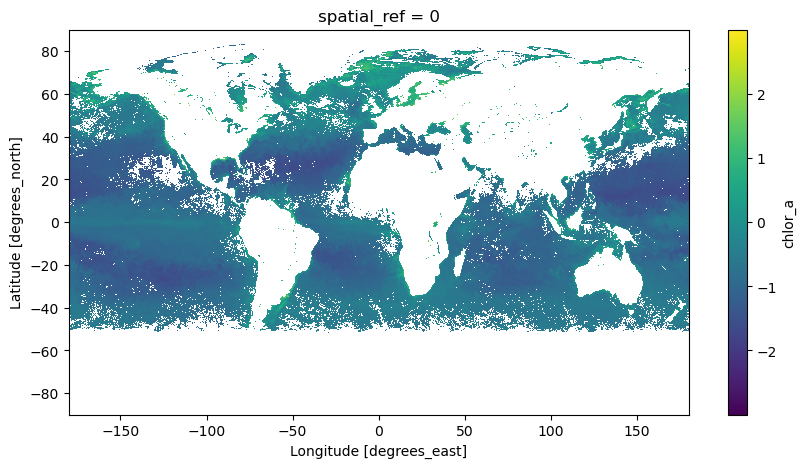

In [5]:
hypercoast.viz_pace_chla(array, cmap="viridis", size=5)

Custermize the dataset and subset it for plotting. First we calculate the mean of the 15-day data.

In [6]:
array_mean = array.mean('date')
array_mean.attrs.update(
    {
        "long_name": f'PACE {array.attrs["long_name"]}',
        "units": f'lg({array.attrs["units"]})',
    }
)

Define the boundary of the area and perform the reduction. Note that the latitude values descend in the index, so the slice will flip the values `lat_bnds = [max_lat, min_lat]`.

In [7]:
min_lon = -179     # lower left longitude
min_lat = 50       # lower left latitude
max_lon = -140     # upper right longitude
max_lat = 72       # upper right latitude

lon_bnds = [min_lon, max_lon]
lat_bnds = [max_lat, min_lat]
array_mean_clip = array_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [8]:
array_mean_clip

<xarray.DataArray 'chlor_a' (lat: 220, lon: 390)> Size: 343kB
dask.array<getitem, shape=(220, 390), dtype=float32, chunksize=(220, 390), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 880B 71.95 71.85 71.75 ... 50.25 50.15 50.05
  * lon          (lon) float32 2kB -178.9 -178.9 -178.8 ... -140.2 -140.1 -140.1
    spatial_ref  int64 8B 0
Attributes:
    long_name:  PACE Chlorophyll Concentration, OCI Algorithm
    units:      lg(lg(mg m^-3))

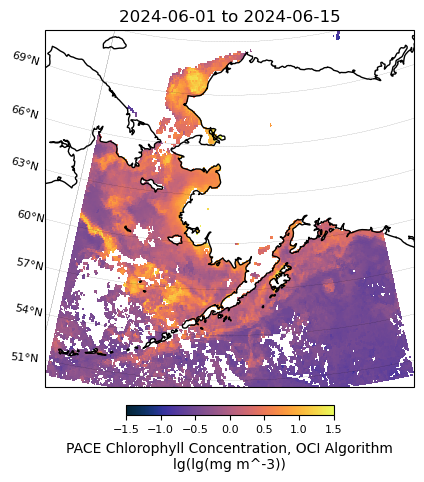

In [9]:
# Plot PACE data
m = regional_plot.plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 2. Download and process SNPP VIIRS data

There are many different ways to obtain L3 data (e.g., from https://oceancolor.gsfc.nasa.gov/l3/) \
Here we show how to get data from NOAA's ERDDAP server (https://oceanwatch.pifsc.noaa.gov/erddap/index.html). ERDDAP is both a data server and a web application developed by NOAA’s Environmental Research Division. It provides a user-friendly web interface for searching, accessing, and visualizing data.

In [10]:
### Uncomment the following lines if you need to download the data for the first time

# import urllib.request 
# url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_daily.nc?chlor_a%5B(2024-06-01T12:00:00Z):1:(2024-06-15T12:00:00Z)%5D%5B(0.0):1:(0.0)%5D%5B(77.00625):1:(50.006249999999994)%5D%5B(180.01875):1:(221.98125000000002)%5D'
# urllib.request.urlretrieve(url, "../data/viirs.nc")

In [11]:
viirs_ds = xr.open_dataset('../data/viirs.nc')

Since the dataset is already subsetted for the area of interest, the next step is to compute the 15-day mean and create plots.

In [12]:
viirs_chla = np.log10(viirs_ds['chlor_a'])
# Calculate the temporal mean
viirs_chla_mean = viirs_chla.mean('time')

viirs_chla_mean.attrs.update(
    {
        "long_name": "SNPP VIIRS, L3 Chlorophyll a Concentration",
        "units": 'lg[lg[{}]]'.format(viirs_ds['chlor_a'].attrs["units"]),
    }
)

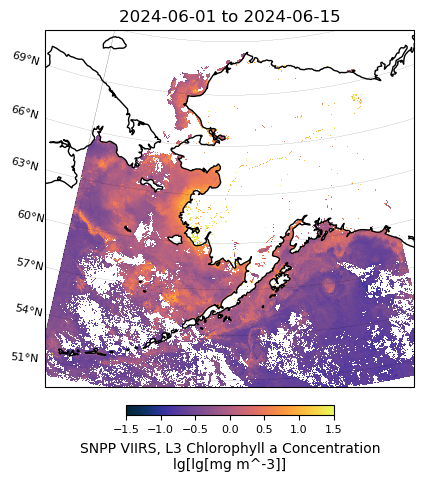

In [13]:
# Plot VIIRS data
m = regional_plot.plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 3. Download and process MODIS data

You may visit [NASA Earthdata Search](https://search.earthdata.nasa.gov/) and enter the short names to read about each data collection. We want to use the `MODISA_L3m_CHL` data collection for our plot. You can retrieve the files (granules) in that collection using `earthaccess.search_data()`.

In [14]:
tspan = ("2023-06-01", "2023-06-15")

# auth = earthaccess.login(persist=True)

# results = earthaccess.search_data(
#     short_name="MODISA_L3m_CHL",
#     granule_name="*.8D*.9km*",
#     temporal=tspan,
# )

# results[0]

By checking the first data, it indicates that the file is not cloud-hosted. We will need to download the data file with `earthaccess.download()`.

In [15]:
# paths = earthaccess.download(results, "../data/modis_chla")

In [16]:
paths = [
    '../data/modis_chla/AQUA_MODIS.20230525_20230601.L3m.8D.CHL.chlor_a.9km.nc',
    '../data/modis_chla/AQUA_MODIS.20230602_20230609.L3m.8D.CHL.chlor_a.9km.nc',
    '../data/modis_chla/AQUA_MODIS.20230610_20230617.L3m.8D.CHL.chlor_a.9km.nc'
]

In [17]:
modis_ds = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
modis_ds

<xarray.Dataset> Size: 112MB
Dimensions:  (date: 3, lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 9kB 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 112MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      AQUA_MODIS.20230525_20230601.L3m.8D.CH...
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    source:                            satellite observations from MODIS-Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2022
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3087431
    data_minimum:                      0.0031313652
    data_maximum:                      86.3219

Similar to previous steps, we calculate the log10 of the chlorophyll concentration, compute the 15-day average, and perform the reduction.

In [18]:
modis_chla = np.log10(modis_ds["chlor_a"])
modis_chla_mean = modis_chla.mean('date')
modis_chla_mean.attrs.update(
    {
        "long_name": f'MODIS {modis_ds["chlor_a"].attrs["long_name"]}',
        "units": f'log({modis_ds["chlor_a"].attrs["units"]})',
    }
)
modis_chla_mean_clip = modis_chla_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [19]:
modis_chla_mean_clip

<xarray.DataArray 'chlor_a' (lat: 264, lon: 468)> Size: 494kB
dask.array<getitem, shape=(264, 468), dtype=float32, chunksize=(264, 468), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 71.96 71.88 71.79 71.71 ... 50.21 50.12 50.04
  * lon      (lon) float32 2kB -179.0 -178.9 -178.8 ... -140.2 -140.1 -140.0
Attributes:
    long_name:  MODIS Chlorophyll Concentration, OCI Algorithm
    units:      log(mg m^-3)

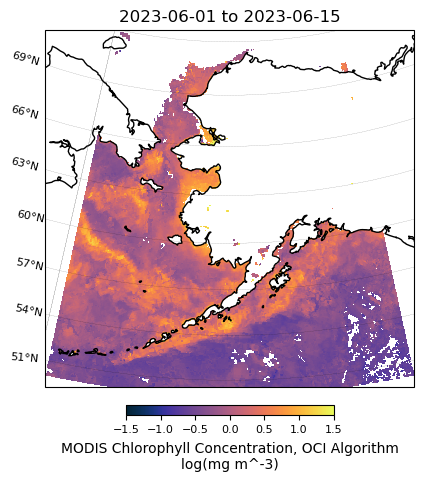

In [20]:
# Plot MODIS data
m = regional_plot.plot_regional_map(modis_chla_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(tspan[0],tspan[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 4. Download and process merged data (OC CCI)

The Ocean Colour Climate Change Initiative (OC CCI) composite of merged sensors is a high-resolution dataset that combines ocean color data from multiple satellite sensors. This composite product aims to provide consistent, global coverage of ocean color, which includes key parameters such as chlorophyll concentration, Kd. By merging data from various sensors, it minimizes gaps and inconsistencies, offering a more reliable and comprehensive view of oceanic biogeochemical properties.

Here we download the daily composit of merged sensor at 1-km resolution from NOAA's ERDDAP server (https://comet.nefsc.noaa.gov/erddap/griddap).

In [21]:
# import urllib.request 
# url = 'https://comet.nefsc.noaa.gov/erddap/griddap/occci_v6_daily_1km.nc?chlor_a%5B(2024-06-01):1:(2024-06-15)%5D%5B(75.00520833333333):1:(49.99479166666667)%5D%5B(-179.99479166666666):1:(-139.99479166666669)%5D'
# urllib.request.urlretrieve(url, "../../data/occci_v6_daily_1km.nc")

In [22]:
occci_ds = xr.open_dataset('../data/occci_v6_daily_1km.nc')

In [23]:
occci_ds

<xarray.Dataset> Size: 554MB
Dimensions:    (time: 15, latitude: 2402, longitude: 3841)
Coordinates:
  * time       (time) datetime64[ns] 120B 2024-06-01 2024-06-02 ... 2024-06-15
  * latitude   (latitude) float64 19kB 75.01 74.99 74.98 ... 50.02 50.01 49.99
  * longitude  (longitude) float64 31kB -180.0 -180.0 -180.0 ... -140.0 -140.0
Data variables:
    chlor_a    (time, latitude, longitude) float32 554MB ...
Attributes: (12/52)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.10, COARDS, ACDD-1.3
    creation_date:                     20240807T105724Z
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2024-06-15T00:00:00Z
    time_coverage_resolution:          P1D
    time_coverage_start:               2024-06-01T00:00:00Z
    title:                             Ocean Color, ESA CCI Ocean Colour Prod...
    tracking_id:                       f70a045f-3da8-4ab1-ae9a-7c75a620f07d
    Westernmost_Easting:               -179.99479166666666

In [24]:
occci_chla = np.log10(occci_ds['chlor_a'])
# Calculate the temporal mean
occci_chla_mean = occci_chla.mean('time')

occci_chla_mean.attrs.update(
    {
        "long_name": "OCCCI Chlorophyll-a Concentration",
        "units": 'lg[lg[{}]]'.format(occci_ds['chlor_a'].attrs["units"]),
    }
)

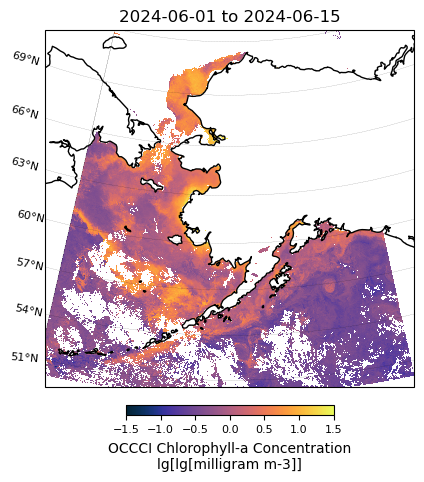

In [25]:
# Plot OCCCI data
m = regional_plot.plot_regional_map(occci_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

[back to top](#Contents)

## 5. Combine the plots side by side

In this step, we will generate a 2x2 figure with four subplots.

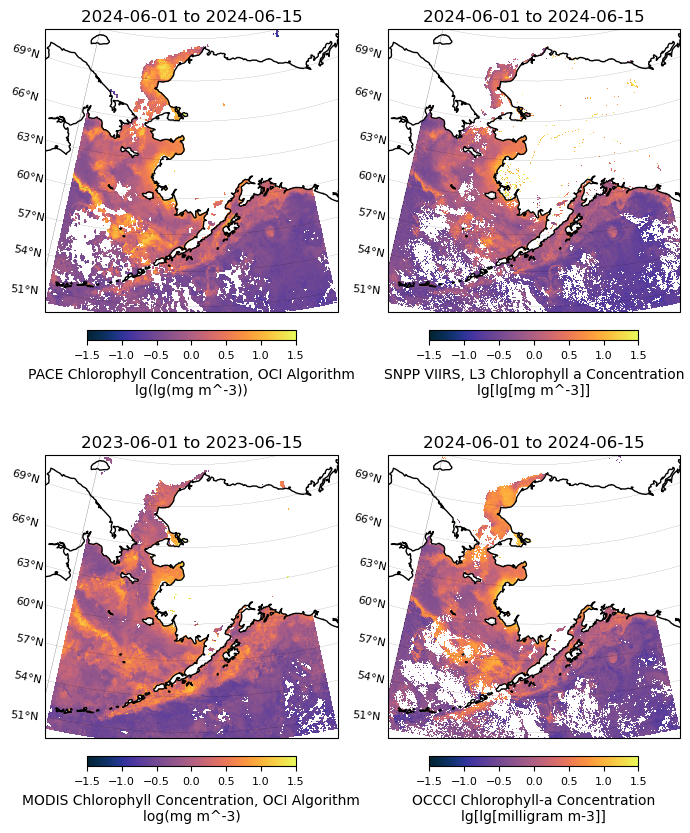

In [26]:
# Calculate central longitude and latitude
central_longitude = (min_lon + max_lon) / 2
central_latitude = (min_lat + max_lat) / 2

# Define projection
projection = ccrs.LambertConformal(central_longitude=central_longitude, 
                                   central_latitude=central_latitude)

# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(7, 9), 
                        subplot_kw={'projection': projection})

# List of datasets and titles
datasets = [array_mean_clip, viirs_chla_mean, modis_chla_mean_clip, occci_chla_mean]
titles = ['{} to {}'.format(temporal[0], temporal[1]),
          '{} to {}'.format(temporal[0], temporal[1]),
          '{} to {}'.format(tspan[0], tspan[1]),
          '{} to {}'.format(temporal[0], temporal[1])]

# Loop through datasets and axes to plot each one
for i, (dataset, title) in enumerate(zip(datasets, titles)):
    ax = axs[i // 2, i % 2]
    regional_plot.plot_regional_map(dataset, min_lon, max_lon, min_lat, max_lat, 
                                    title=title, vmin=-1.5, vmax=1.5, ax=ax)

fig.tight_layout()

[back to top](#Contents)